# Bayesian Randomized Benchmarking

This is a bayesian [PyMC3](https://doi.org/10.7717/peerj-cs.55) implementation on top of frequentist models for standard and interleaved randomized benchmarking (RB) featured in qiskit experiments.

Based on the tutorial [randomized_benchmarking](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb). The RB parameters and the analysis variables are identical. 

The protocols for standard and interleaved RB are described in the first two entries of Table 1 of [this paper](https://arxiv.org/abs/1802.00401). The Bayesian hierarchical models are based on equation 13 of the same paper.

The serial Monte Carlo (SMC) algorithm used for posterior sampling is the [No-U-Turn Sampler](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) featured in [PyMC3](https://doi.org/10.7717/peerj-cs.55). 

[ArviZ](https://joss.theoj.org/papers/10.21105/joss.01143) is used for the exploratory analysis of the results.

This demo shows that the bayesian approach delivers on simulator a good estimation of the error per Clifford and per gate, within narrow bounds.

In [1]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# import the bayesian packages
import pymc3 as pm
import arviz as az
import bayesian_fitter_utils as bf

# define backend
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis
backend = AerSimulator.from_backend(FakeParis())

## *Standard RB*

In this section the tying function is: $$GSP=a \cdot \alpha^m + b$$ 

where $GSP$ is the ground state population and $m$ is the Clifford length

The three tying hyperparameters in the hierarchical bayesian model are (in that order): $a$, $\alpha$ and $b$ 

### One-qubit  RB

In [2]:
# describe RB experiment 
qubits = [0]
lengths = np.arange(1, 2500, 250)
num_samples = 10
seed = 3019

#### Running circuits using Qiskit experiments

In [3]:
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

In [4]:
#prepare circuits
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
#run
expdata1 = exp1.run(backend).block_for_results()

   #### Preparing for SMC

In [5]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)
interleaved_gate = "" # for plot title
experiment_type = expdata1._data[0]['metadata']['experiment_type']
physical_qubits = expdata1._data[0]['metadata']['physical_qubits']
shots = expdata1._data[0]['shots']
# to compare ultimately: EPC and sigma(EPC) by LSF
epc_est_fm = expdata1.analysis_results()[2].value.value
epc_est_fm_err = expdata1.analysis_results()[2].value.stderr

In [6]:
# get count data and other values from expdata1
Y = bf.get_GSP_counts(expdata1._data, m_len,
                    range(num_samples))

In [7]:
X = np.copy(lengths)
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

####  Running serial Monte Carlo algorithm



In [8]:
model = "hierarchical model"

In [9]:
# priors for unknown model parameters
T_priors = expdata1.analysis_results()[0].value.value
print(T_priors)

[0.47491595 0.99832209 0.51109653]


In [10]:
testval_s = 0.001
upper_s = 0.004
lower_s = 0.0001
alpha_Gamma = 10
beta_Gamma = 10000

h_model = bf.create_model(T_priors, X, Y, shots, scale,
                          testval_s = testval_s ,upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)

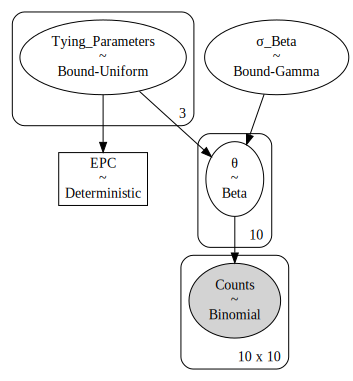

In [11]:
# model graph                                
pm.model_to_graphviz(h_model)

In [12]:
# sample
with h_model:
    trace_h = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 274 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


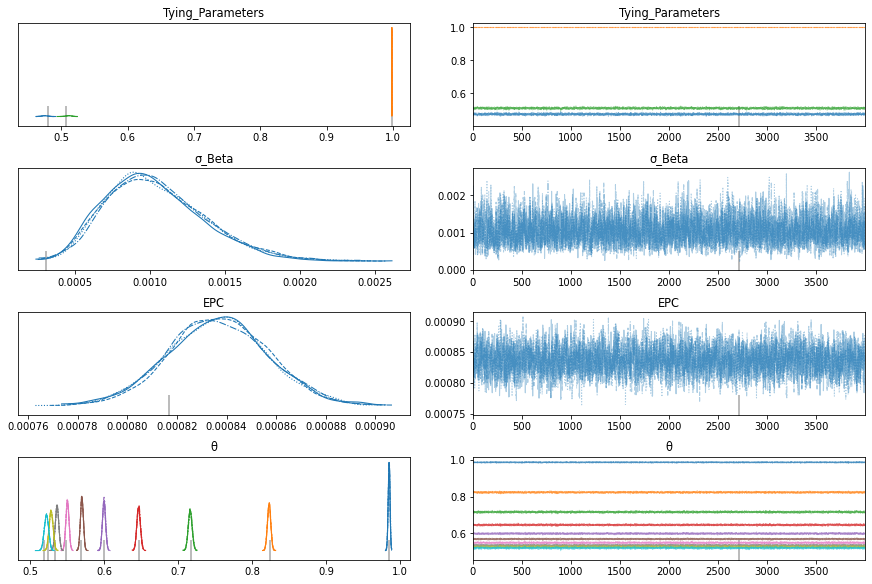

In [13]:
with h_model:
        az.plot_trace(trace_h);

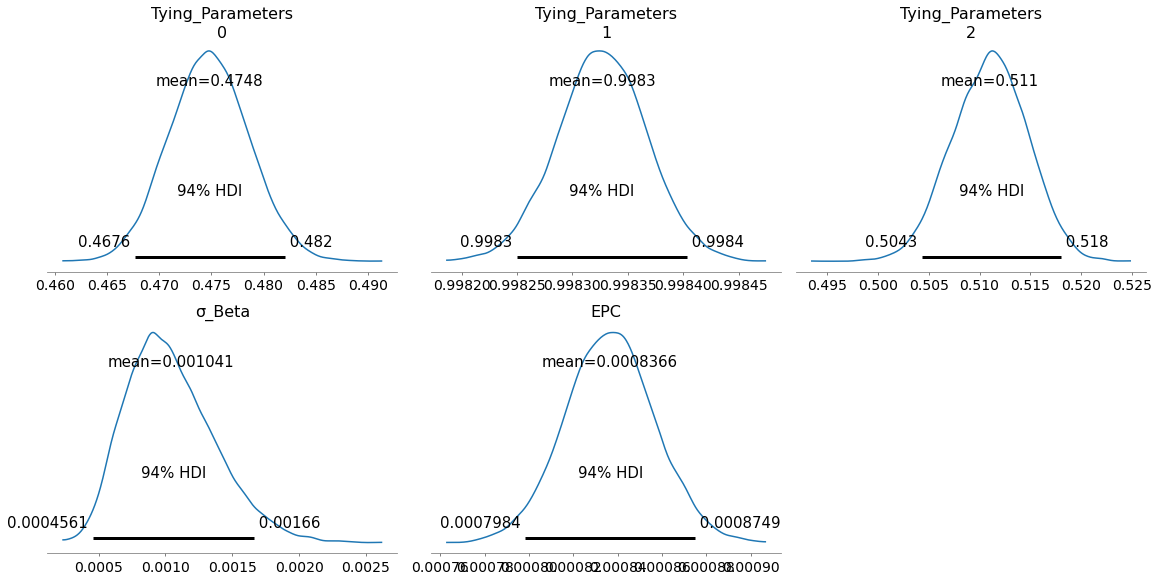

In [14]:
with h_model:
    az.plot_posterior(trace_h, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [15]:
# look at the posterior values of the hyperparameters:
with h_model:
    #  (hdi_prob=.94 is default)
    azt_summary = az.summary(trace_h, round_to=12,
                            var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                            kind="stats") 
azt_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.474802,0.003828,0.467648,0.482039
Tying_Parameters[1],0.998327,0.000040,0.998250,0.998403
Tying_Parameters[2],0.511010,0.003679,0.504301,0.517994
σ_Beta,0.001041,0.000333,0.000456,0.001660
EPC,0.000837,0.000020,0.000798,0.000875


In [16]:
# for comparison
# reference
epc_calib = np.nan
# bayesian
epc_est_a = azt_summary['mean']['EPC']
epc_est_a_err = azt_summary['sd']['EPC']
# frequentist
epc_est_fm = expdata1.analysis_results()[2].value.value
epc_est_fm_err = expdata1.analysis_results()[2].value.stderr

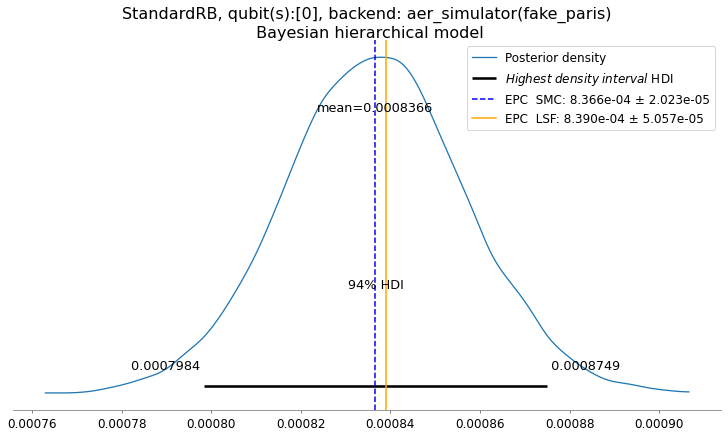

In [17]:
epc_title = experiment_type +', qubit(s):' + str(physical_qubits)\
                         +', backend: '+backend.name() + "\n Bayesian "+model

bf.plot_epc(h_model, trace_h, epc_calib, epc_est_a,
             epc_est_a_err, epc_est_fm, epc_est_fm_err, epc_title)

In [18]:
# backend's recorded EPG
error_dic = RBUtils.get_error_dict_from_backend(backend, qubits)

# get the EPG values
EPG_dic = {}
REF_dic = {}
for i in range(3,6):
    EPG_key = expdata1.analysis_results()[i].name
    EPG_dic[EPG_key] = expdata1.analysis_results()[i].value.value
    for elem in (error_dic):
        if 'EPG_' + elem[1] == EPG_key:
            REF_dic[EPG_key] = error_dic[elem]      

In [19]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian      Reference")
print("________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm, epc_est_a, epc_calib ))  
print("± sd       ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

for i, (gate,EPG) in enumerate(EPG_dic.items()):
    print("{0:<12}{1:1.3e}        {2:1.3e}      {3:1.3e} "
      .format(gate, EPG, EPG*epc_est_a/epc_est_fm,
             REF_dic[gate])) 

Model:    Frequentist         Bayesian      Reference
________________________________________________________
EPC         8.390e-04        8.366e-04         nan
± sd       ± 5.057e-05      ± 2.023e-05 
EPG_rz      0.000e+00        0.000e+00      0.000e+00 
EPG_sx      4.376e-04        4.364e-04      4.432e-04 
EPG_x       4.376e-04        4.364e-04      4.432e-04 


#### GSP plot

In [20]:
# prepare box for GSP plot
texto =  "alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[1]'],
            azt_summary['sd']['Tying_Parameters[1]']) + "\n"                                             
                                           
texto += "EPC = {0:1.4e} ± {1:1.4e}"\
            .format(azt_summary['mean']['EPC'],
            azt_summary['sd']['EPC']) + "\n"

for i, (gate,EPG) in enumerate(EPG_dic.items()):
    texto += "   {0:<8} = {1:1.4e}         "\
              .format(gate.ljust(6), EPG*epc_est_a/epc_est_fm) + "\n"               

texto += "             Fit χ² = {0:7.4f} "\
            .format(bf.reduced_chisquare(y_mean, sigma_y, trace_h))

In [21]:
bounds_rmk, y1, y1_min, y1_max = bf.prepare_data_GSP_plot(h_model, trace_h, HDI = False)

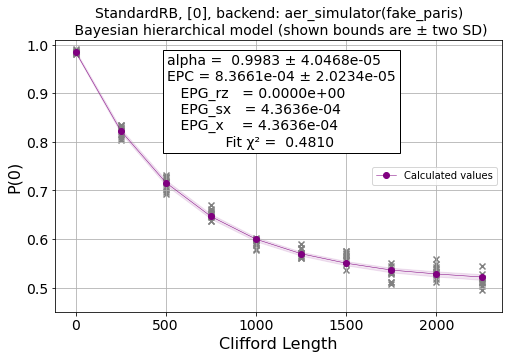

In [22]:
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2=None, y2_min=None, y2_max=None, Y1=Y, Y2=None,
         first_curve = "Calculated values", second_curve = None)

#### Comparing with frequentist model results

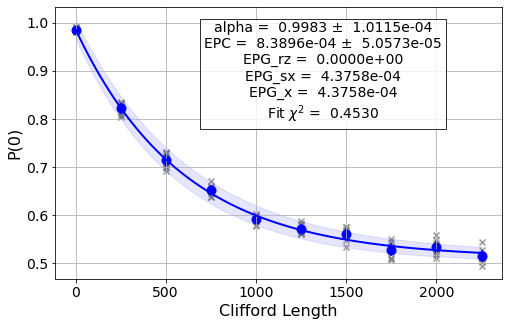

In [23]:
# View data for frequentist model
display(expdata1.figure(0))

### Two-qubit  RB

In [24]:
lengths = np.arange(1, 200, 15)
num_samples = 10
seed = 3019
qubits = (1,4)

In [25]:
# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
expdata_1q = {}
epg_1q = []
lengths_1_qubit = np.arange(1, 2500, 250)
for qubit in qubits:
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend).block_for_results()
    expdata_1q[qubit] = expdata
    epg_1q += expdata.analysis_results()

In [26]:
# Run an RB experiment on qubits 1, 4
exp2 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_1q)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend).block_for_results()

# View result data
results2 = expdata2.analysis_results()

In [27]:
# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
expected_epg = RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_results("EPG_cx").value

print("Backend's reported EPG of the cx gate:", expected_epg)
print("Experiment computed EPG of the cx gate:", exp2_epg)

Backend's reported EPG of the cx gate: 0.012438847900902494
Experiment computed EPG of the cx gate: 0.012112815910674583


#### Preamble: 2 x 1-Qubit RB

In [28]:
trace_1q = {}
scale_1q = .5
for qubit in qubits:
    Y = bf.get_GSP_counts(expdata_1q[qubit]._data, len(lengths_1_qubit),
                    range(num_samples))
    X = np.copy(lengths_1_qubit)    
    shots_1_qubit = expdata_1q[qubit]._data[0]['shots']
    T_priors = expdata_1q[qubit].analysis_results()[0].value.value
    
    testval_s = 0.001
    upper_s = 0.004
    lower_s = 0.0001
    alpha_Gamma = 10
    beta_Gamma = 10000

    h1_model = bf.create_model(T_priors, X, Y, shots_1_qubit, scale_1q,
                          testval_s = testval_s ,upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)  
    with h1_model:
        trace_h1 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                             return_inferencedata=True)
    trace_1q[qubit] = trace_h1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 303 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 214 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


   #### Preparing for SMC

In [29]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)
interleaved_gate = "" # for plot title
experiment_type = expdata2._data[0]['metadata']['experiment_type']
physical_qubits = expdata2._data[0]['metadata']['physical_qubits']
shots = expdata2._data[0]['shots']

In [30]:
# get count data and other values from expdata2
Y = bf.get_GSP_counts(expdata2._data, m_len,
                    range(num_samples))

In [31]:
X = np.copy(lengths)
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

####  Running serial Monte Carlo algorithm


In [32]:
model = "hierarchical model"

In [33]:
# priors for unknown model parameters
T_priors = expdata2.analysis_results()[0].value.value
print(T_priors)

[0.6990531  0.97174062 0.2644996 ]


In [34]:
testval_s = 0.0025
upper_s = 0.005
lower_s = 0.0005
alpha_Gamma = 5
beta_Gamma = 2000
h2_model = bf.create_model(T_priors, X, Y, shots, scale,
                          testval_s = testval_s ,upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)

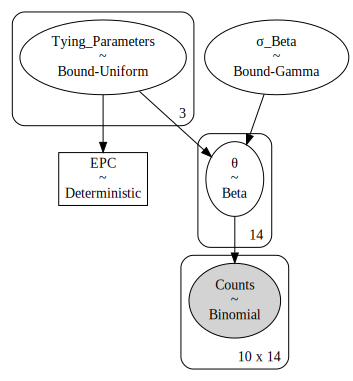

In [35]:
# model graph                                
pm.model_to_graphviz(h2_model)

In [36]:
# sample
with h2_model:
    trace_h2 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 187 seconds.
The number of effective samples is smaller than 25% for some parameters.


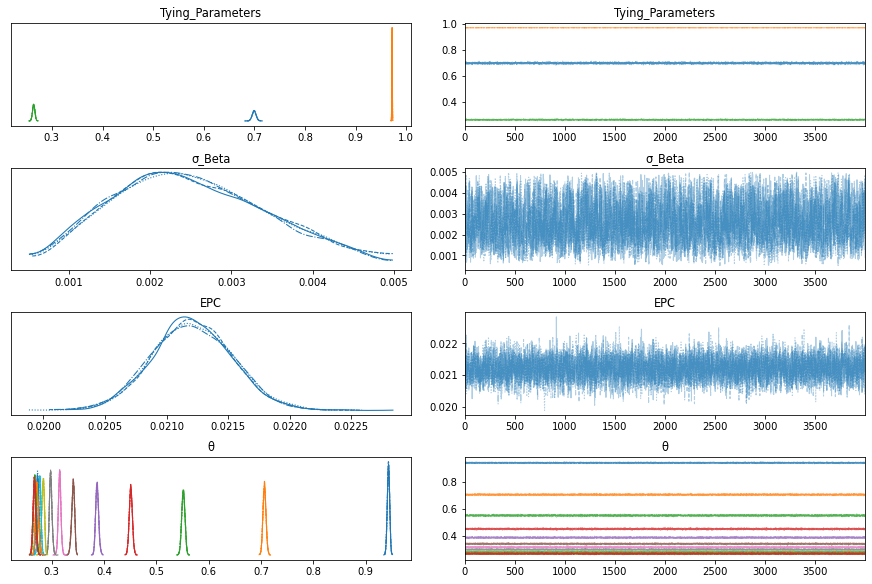

In [37]:
with h2_model:
        az.plot_trace(trace_h2);

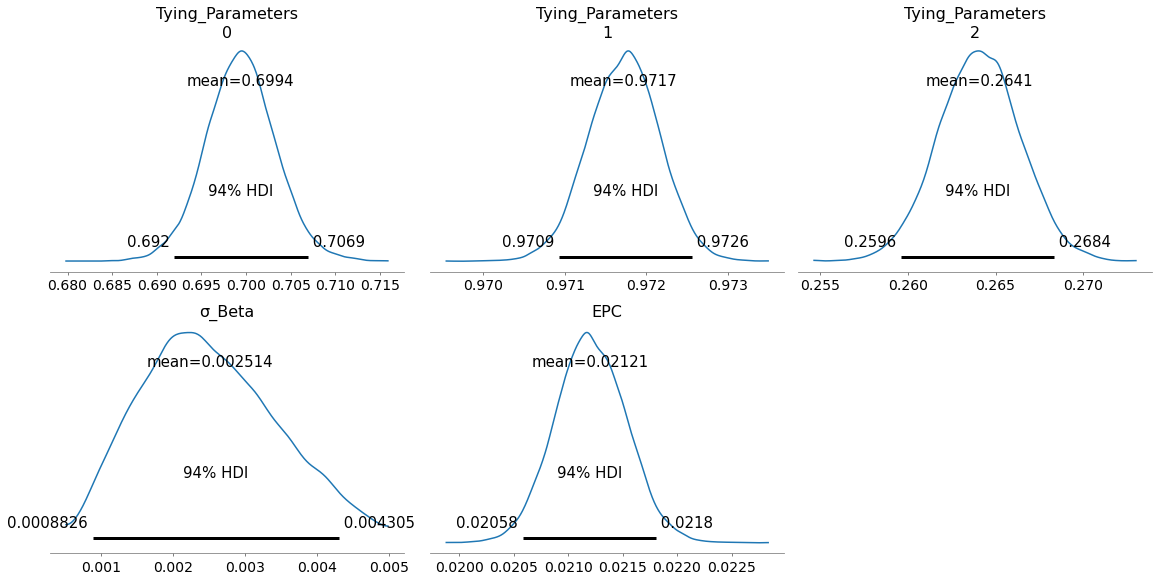

In [38]:
with h2_model:
    az.plot_posterior(trace_h2, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [39]:
# look at the posterior values of the hyperparameters:
with h2_model:
    #  (hdi_prob=.94 is default)
    azt2_summary = az.summary(trace_h2, round_to=12,
                            var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                            kind="stats") 
azt2_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.699405,0.003941,0.691952,0.706910
Tying_Parameters[1],0.971723,0.000436,0.970927,0.972555
Tying_Parameters[2],0.264075,0.002338,0.259590,0.268353
σ_Beta,0.002514,0.000941,0.000883,0.004305
EPC,0.021208,0.000327,0.020584,0.021805


In [40]:
# for comparison
# reference
epc_calib = np.nan
# bayesian
epc_est_a = azt2_summary['mean']['EPC']
epc_est_a_err = azt2_summary['sd']['EPC']
# frequentist
epc_est_fm = expdata2.analysis_results()[2].value.value
epc_est_fm_err = expdata2.analysis_results()[2].value.stderr

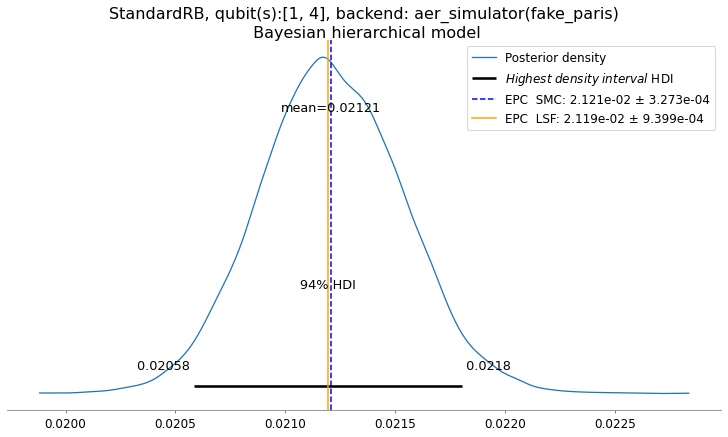

In [41]:
epc_title = experiment_type +', qubit(s):' + str(physical_qubits)\
                         +', backend: '+backend.name() + "\n Bayesian "+model

bf.plot_epc(h2_model, trace_h2, epc_calib, epc_est_a,
             epc_est_a_err, epc_est_fm, epc_est_fm_err, epc_title)

In [42]:
# obtain posterior values of the hyperparameters:
azts_1q = []
for i_qubit, qubit in enumerate(qubits):
    with h2_model:
        #  (hdi_prob=.94 is default)
        azts_1q.append( az.summary(trace_1q[qubit], round_to=12,
                                var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                                kind="stats") ) 

In [43]:
# retrieve gates per clifford from frequentist results  
alpha_1q = [epg_1q[1].value.value, epg_1q[7].value.value]
epc_2_qubit = expdata2.analysis_results()[2].value.value
alpha_c_1q = 1 / 5 * (alpha_1q[0] + alpha_1q[1] + 3 * alpha_1q[0] * alpha_1q[1])
alpha_c_2q = (1 - 4 / 3 * epc_2_qubit)  / alpha_c_1q
n_gate_2q = 3 / 4 * (1 - alpha_c_2q) / exp2_epg.value

In [44]:
# calculate epg cx from the bayesian results
alpha_1q_b = [azts_1q[0]['mean']['Tying_Parameters[1]'],
              azts_1q[1]['mean']['Tying_Parameters[1]']]
epc_2_qubit_b = azt2_summary['mean']['EPC']

alpha_c_1q_b = 1 / 5 * (alpha_1q_b[0] + alpha_1q_b[1] + 3 * alpha_1q_b[0] * alpha_1q_b[1])
alpha_c_2q_b = (1 - 4 / 3 * epc_2_qubit_b)  / alpha_c_1q_b
epg_cx = 3 / 4 * (1 - alpha_c_2q_b) / n_gate_2q

In [45]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian      Reference")
print("________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}      -----"
      .format(epc_est_fm, epc_est_a )) 
print("± sd       ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))
print("EPG_cx      {0:1.3e}        {1:1.3e}      {2:1.3e}"
      .format(exp2_epg.value, epg_cx, expected_epg))  

Model:    Frequentist         Bayesian      Reference
________________________________________________________
EPC         2.119e-02        2.121e-02      -----
± sd       ± 9.399e-04      ± 3.273e-04 
EPG_cx      1.211e-02        1.210e-02      1.244e-02


#### GSP plot

In [46]:
# prepare box for GSP plot

texto = "  alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt2_summary['mean']['Tying_Parameters[1]'],
            azt2_summary['sd']['Tying_Parameters[1]'])  + "\n"                                            
                                           
texto += "   EPC = {0:1.4e} ± {1:1.4e}"\
            .format(azt2_summary['mean']['EPC'],
            azt2_summary['sd']['EPC']) + "\n"

texto += "         EPG_cx = {0:7.4f}"\
            .format(epg_cx) + "\n" 
           

texto += "             Fit χ² = {0:7.4f} "\
            .format(bf.reduced_chisquare(y_mean, sigma_y, trace_h2))


In [47]:
bounds_rmk, y1, y1_min, y1_max = bf.prepare_data_GSP_plot(h2_model, trace_h2)

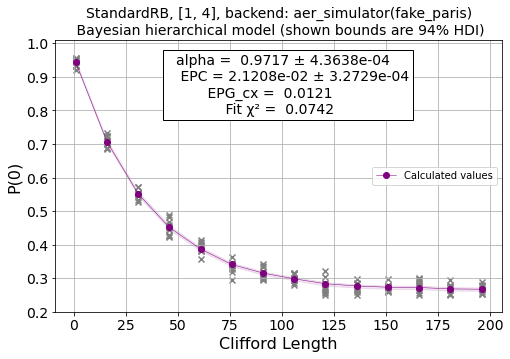

In [48]:
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2=None, y2_min=None, y2_max=None, Y1=Y, Y2=None,
         first_curve = "Calculated values", second_curve = None)

#### Comparing with frequentist model results

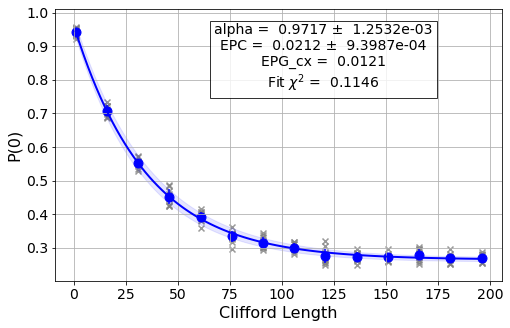

In [49]:
# View result for frequentist model
display(expdata2.figure(0))

## *Interleaved  RB*

In this section the tying function is: 
$$GSP = \begin{cases}
a \cdot \alpha^m + b &\text{ if mode is reference } \\
a \cdot (\alpha\cdot\alpha_C)^m\ + b &\text{ if mode is interleaved } \\
\end{cases}$$

where $GSP$ is the ground state population and $m$ is the Clifford length

The four tying hyperparameters in the hierarchical bayesian model are (in that order): $a$, $\alpha$ , $\alpha_C$ and $b$ 

### One-qubit  RB

In [50]:
interleaved_gate = "x"
interleaved_circuit = circuits.XGate()
qubits = [0]
lengths = np.arange(1, 2500, 250)
testval_s = 0.001
upper_s = 0.004
lower_s = 0.0005
alpha_Gamma = 10
beta_Gamma = 10000
num_samples = 10
seed = 3019

In [51]:
epc_calib = REF_dic['EPG_' + interleaved_gate]
print('EPC reference:    {0:1.4e}'.format(epc_calib))  

EPC reference:    4.4321e-04


#### Running circuits using Qiskit experiments

In [52]:
#prepare circuits
int1exp = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)
#run
int1expdata = int1exp.run(backend).block_for_results()

   #### Preparing for SMC

In [53]:
experiment_type = int1expdata._data[0]['metadata']['experiment_type']
physical_qubits = int1expdata._data[0]['metadata']['physical_qubits']
shots = int1expdata._data[0]['shots']
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)

In [54]:
# get count data and other values from int1expdata
Y = bf.get_GSP_counts(int1expdata._data, 2*m_len,
                    range(num_samples))

In [55]:
# get RvsI_h and IvsR_h
RvsI_h = np.ones(2*m_len) 
for i_data in range(2*m_len):
    if int1expdata._data[i_data]['metadata']['interleaved']:
            RvsI_h[i_data] = 0.  
IvsR_h = (RvsI_h + 1.) %2

In [56]:
X0 = np.tile(lengths,2)
X = np.vstack((X0,RvsI_h,IvsR_h))
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

####  Running serial Monte Carlo algorithm

In [57]:
model = "hierarchical model"

In [58]:
# priors for unknown model parameters
T_priors = int1expdata.analysis_results()[0].value.value
print(T_priors)

[0.47578987 0.99830254 0.99916102 0.50914234]


In [59]:
hv1 = bf.create_model(T_priors, X, Y, shots, scale,
                          testval_s = testval_s, upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)

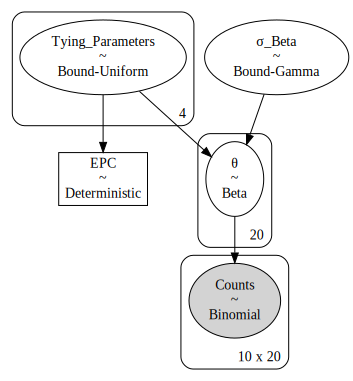

In [60]:
# model graph                                
pm.model_to_graphviz(hv1)

In [61]:
# sample
with hv1:
    trace_hv1 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 299 seconds.
The number of effective samples is smaller than 25% for some parameters.


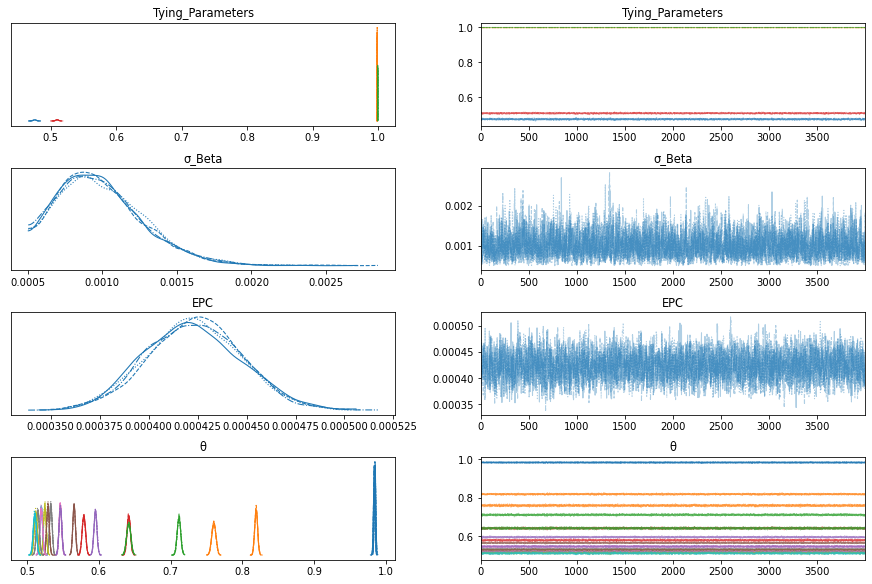

In [62]:
with hv1:
        az.plot_trace(trace_hv1);

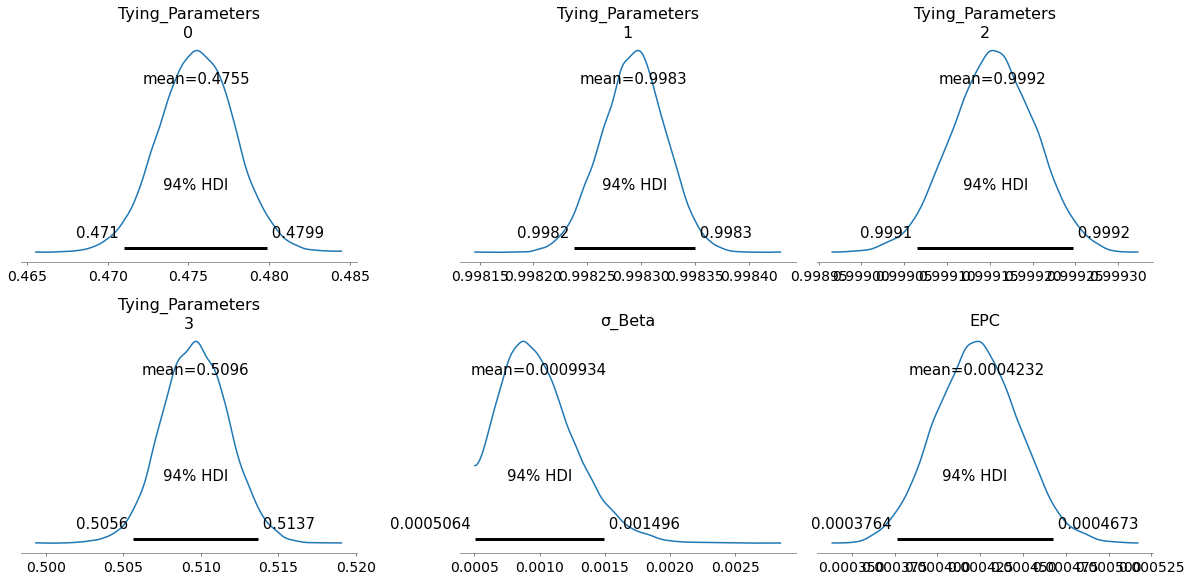

In [63]:
with hv1:
    az.plot_posterior(trace_hv1, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [64]:
# look at the posterior values of the hyperparameters:
with hv1:
    #  (hdi_prob=.94 is default)
    aztv1_summary = az.summary(trace_hv1, round_to=12,                            
                             var_names = ["Tying_Parameters","σ_Beta","EPC"],
                             kind="stats")
aztv1_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.475513,0.002358,0.470980,0.479853
Tying_Parameters[1],0.998293,0.000030,0.998238,0.998350
Tying_Parameters[2],0.999154,0.000049,0.999065,0.999247
Tying_Parameters[3],0.509650,0.002161,0.505647,0.513707
σ_Beta,0.000993,0.000291,0.000506,0.001496
EPC,0.000423,0.000024,0.000376,0.000467


In [65]:
# for comparison
# bayesian
epc_est_a = aztv1_summary['mean']['EPC']
epc_est_a_err = aztv1_summary['sd']['EPC']
# frequentist
epc_est_fm = int1expdata.analysis_results()[3].value.value
epc_est_fm_err = int1expdata.analysis_results()[3].value.stderr

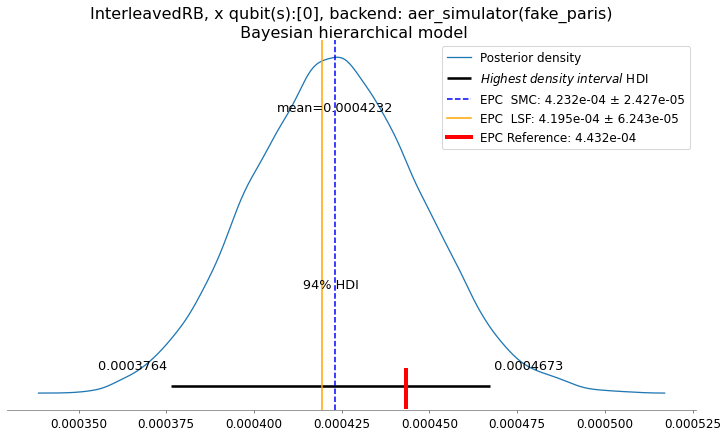

In [66]:
epc_title = experiment_type +', ' + interleaved_gate  \
            + " qubit(s):" + str(physical_qubits)\
            +', backend: '+ backend.name() + "\n Bayesian "+model
bf.plot_epc(hv1, trace_hv1, epc_calib, epc_est_a,
             epc_est_a_err, epc_est_fm, epc_est_fm_err, epc_title)

In [67]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian         Reference")
print("__________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm,epc_est_a,epc_calib ))  
print("± sd       ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

Model:    Frequentist         Bayesian         Reference
__________________________________________________________
EPC         4.195e-04        4.232e-04         4.432e-04
± sd       ± 6.243e-05      ± 2.427e-05 


#### GSP plot

In [68]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

In [69]:
# obtain data for plot
bounds_rmk, y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2 = \
  bf.prepare_two_curves_GSP_plot(hv1, trace_hv1, X, Y, HDI = False)

In [70]:
reduced_chisq = bf.reduced_chisquare(y_mean, sigma_y, trace_hv1)
texto = bf.get_box_interleaved(aztv1_summary, reduced_chisq)

In [71]:
title = experiment_type +', ' + interleaved_gate\
      + str(physical_qubits)\
      +', backend: '+backend.name()+\
      "\n Bayesian "+model+" "+ bounds_rmk

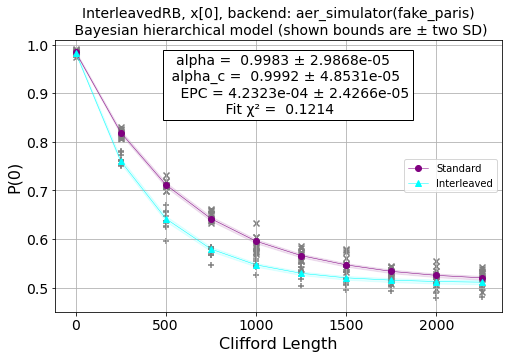

In [72]:
# plot
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2,
         first_curve = "Standard", second_curve = "Interleaved")

#### Comparing with frequentist model results

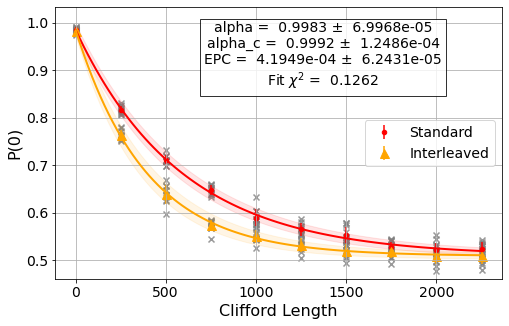

In [73]:
# View result  for frequentist model
display(int1expdata.figure(0))

### Two-qubit  RB

In [74]:
interleaved_gate = "cx"
interleaved_circuit = circuits.CXGate()
qubits = [1,4]
lengths = np.arange(1, 200, 15)
testval_s = 0.0025
upper_s = 0.005
lower_s = 0.0005
alpha_Gamma = 5
beta_Gamma = 2000
num_samples = 10
seed = 3019

In [75]:
epc_calib = expected_epg
print('EPC reference:    {0:1.4e}'.format(epc_calib)) 

EPC reference:    1.2439e-02


#### Running circuits using Qiskit experiments

In [76]:
#prepare circuits
int_exp = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)
#run
int_expdata = int_exp.run(backend).block_for_results()

  #### Preparing for SMC

In [77]:
experiment_type = int_expdata._data[0]['metadata']['experiment_type']
physical_qubits = int_expdata._data[0]['metadata']['physical_qubits']
shots = int_expdata._data[0]['shots']
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)

In [78]:
# get count data and other values from int_expdata
Y = bf.get_GSP_counts(int_expdata._data, 2*m_len,
                    range(num_samples))

In [79]:
# get RvsI_h and IvsR_h
RvsI_h = np.ones(2*m_len) 
for i_data in range(2*m_len):
    if int_expdata._data[i_data]['metadata']['interleaved']:
            RvsI_h[i_data] = 0.  
IvsR_h = (RvsI_h + 1.) %2

In [80]:
X0 = np.tile(lengths,2)
X = np.vstack((X0,RvsI_h,IvsR_h))
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

####  Running serial Monte Carlo algorithm

In [81]:
model = "hierarchical model"

In [82]:
# priors for unknown model parameters
T_priors = int_expdata.analysis_results()[0].value.value
print(T_priors)

[0.70570147 0.971729   0.98326271 0.26166069]


In [83]:
hv2 = bf.create_model(T_priors, X, Y, shots, scale,
                          testval_s = testval_s, upper_s = upper_s, lower_s = lower_s,
                          s_prior = "Gamma", alpha_Gamma = alpha_Gamma, beta_Gamma = beta_Gamma)

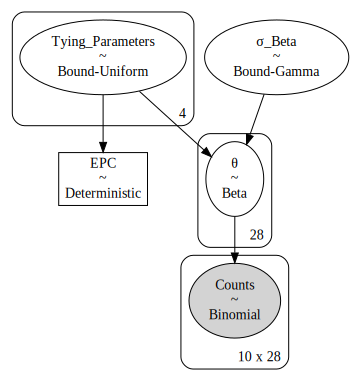

In [84]:
# model graph                                
pm.model_to_graphviz(hv2)

In [85]:
# sample
with hv2:
    trace_hv2 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 213 seconds.
The number of effective samples is smaller than 10% for some parameters.


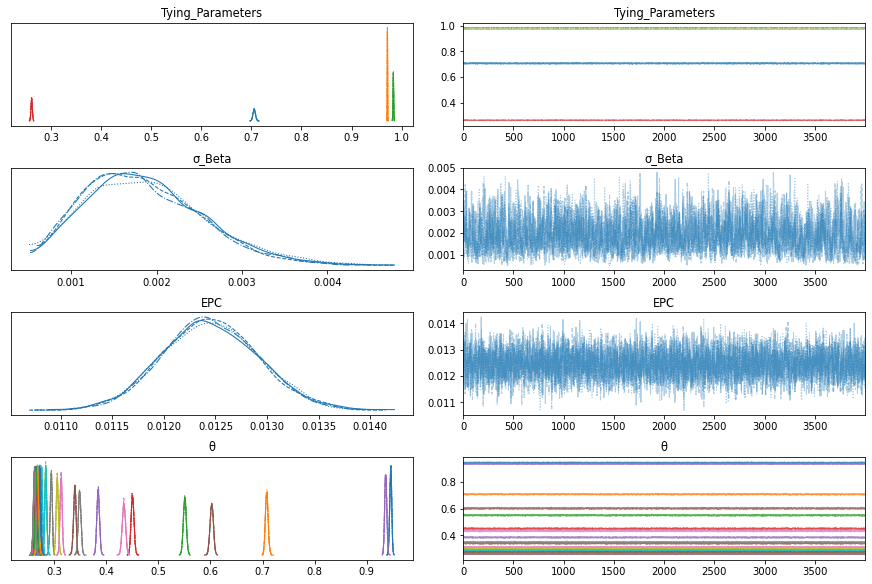

In [86]:
with hv2:
        az.plot_trace(trace_hv2);

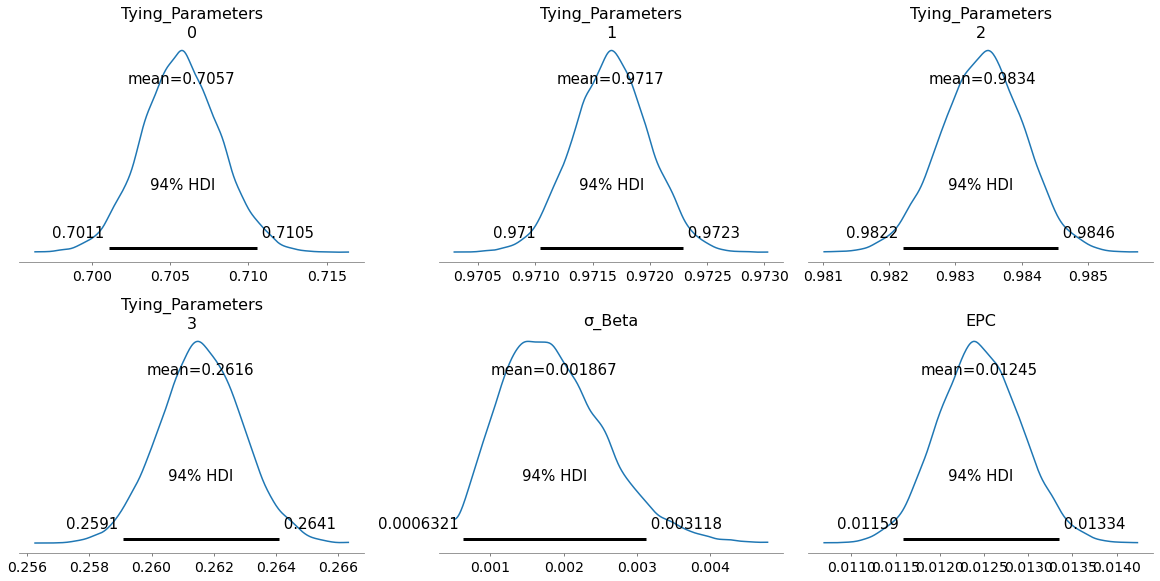

In [87]:
with hv2:
    az.plot_posterior(trace_hv2, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [88]:
# look at the posterior values of the hyperparameters:
with hv2:
    #  (hdi_prob=.94 is default)
    aztv2_summary = az.summary(trace_hv2, round_to=12,                            
                             var_names = ["Tying_Parameters","σ_Beta","EPC"],
                             kind="stats")
aztv2_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.705694,0.002498,0.701118,0.710545
Tying_Parameters[1],0.971660,0.000335,0.971042,0.972289
Tying_Parameters[2],0.983400,0.000627,0.982209,0.984553
Tying_Parameters[3],0.261585,0.001327,0.259064,0.264085
σ_Beta,0.001867,0.000699,0.000632,0.003118
EPC,0.012450,0.000470,0.011585,0.013343


In [89]:
# for comparison
# bayesian
epc_est_a = aztv2_summary['mean']['EPC']
epc_est_a_err = aztv2_summary['sd']['EPC']
# frequentist
epc_est_fm = int_expdata.analysis_results()[3].value.value
epc_est_fm_err = int_expdata.analysis_results()[3].value.stderr

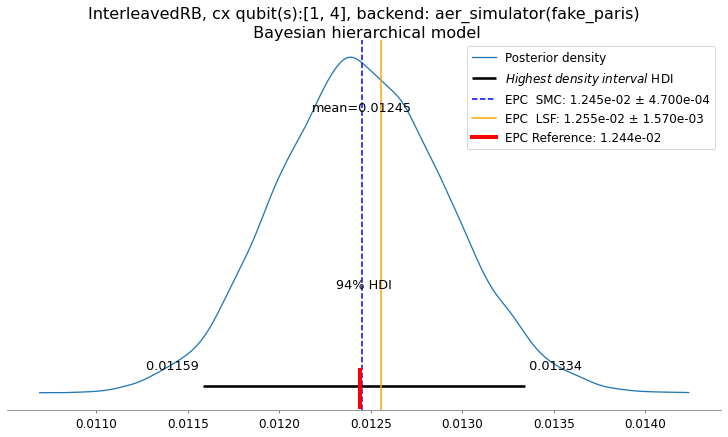

In [90]:
epc_title = experiment_type +', ' + interleaved_gate  \
            + " qubit(s):" + str(physical_qubits)\
            +', backend: '+ backend.name() + "\n Bayesian "+model
bf.plot_epc(hv2, trace_hv2, epc_calib, epc_est_a,
             epc_est_a_err, epc_est_fm, epc_est_fm_err, epc_title)

In [91]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian         Reference")
print("__________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm,epc_est_a,epc_calib ))  
print("± sd       ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

Model:    Frequentist         Bayesian         Reference
__________________________________________________________
EPC         1.255e-02        1.245e-02         1.244e-02
± sd       ± 1.570e-03      ± 4.700e-04 


#### GSP plot

In [92]:
# obtain data for plot
bounds_rmk, y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2 = \
  bf.prepare_two_curves_GSP_plot(hv2, trace_hv2, X, Y, HDI = False)

In [93]:
reduced_chisq = bf.reduced_chisquare(y_mean, sigma_y, trace_hv2)
texto = bf.get_box_interleaved(aztv2_summary, reduced_chisq)

In [94]:
title = experiment_type +', ' + interleaved_gate\
      + str(physical_qubits)\
      +', backend: '+backend.name()+\
      "\n Bayesian "+model+" "+ bounds_rmk

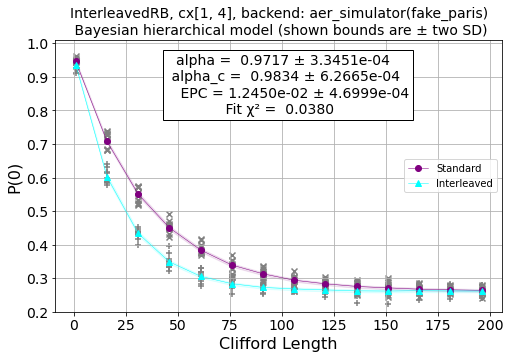

In [95]:
# plot
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2,
         first_curve = "Standard", second_curve = "Interleaved")

#### Comparing with frequentist model results

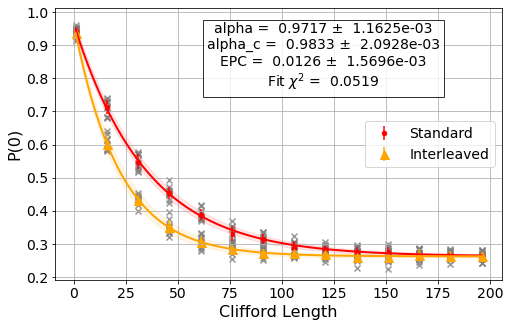

In [96]:
# View result  for frequentist model
display(int_expdata.figure(0))